## Før data kan lastes inn i Dapla, må prosjektet verdivurderes.

### Wiki:
https://statistics-norway.atlassian.net/wiki/spaces/MS/pages/1586204629/Sikkerhet+tilgangstyring+og+verdivurdering

### Søknadsskjema:
https://statistics-norway.atlassian.net/wiki/spaces/MS/pages/1586204634/Detaljert+verdivurderingsskjema \
https://forms.office.com/Pages/ResponsePage.aspx?id=knAhx0CyHU69YfqXupdcvPjLR5CvmVJPkv_6VrpLQiVUQzNLUFZIWVRJTFpWUERaN1NGNFNCRkJKMi4u

## Etter verdivurdering må det gjennom "ingest"
Spør om hjelp i slack-kanalen: \
https://ssb-norge.slack.com/archives/C0151FGR10X \
Prosessen har en tendens til å endre seg...

Her er det siste, Fenglin om hvordan han ønsker behov innmeldt: \
https://ssb-norge.slack.com/archives/C0151FGR10X/p1622538309010100

## Ved skriving til dapla-lagringen
Så skal verdivurderingen inn i koden.

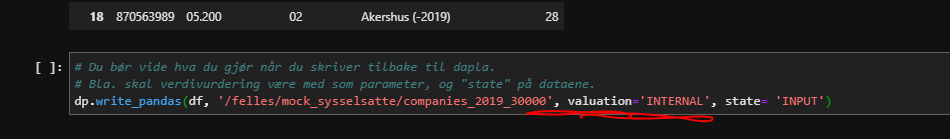

### Konvertering fra spark-dataframe til pandas dataframe
Råformatet det lastes inn i, er ikke nødvendigvis klart for pandas. \
Når koden under kjøres, så må "kernelen" være satt til pyspark. \
Det er ikke sikkert du trenger å forstå hele denne koden, men den bør inn som en del av produksjonsløpet.

In [4]:
# Eksempel på konvertering fra KAG (koden vil kun funke om du har tilgang til dataene du skal se på)
from ssb_sparktools.processing import processing as stproc

in_path = '/kilde/ssb/kag/AVS_GRSK_G2019_FNR/rådata/202105030941'
out_path = '/produkt/kag/klargjort/20192020/utpakket/resultat'

spark_path = spark.read.path(in_path)
spark_dict = stproc.unpack_parquet(spark_path, rootdf=False)

# Se på datasettet
#spark_dict

{'manifest_collector_metadata': DataFrame[manifest_id: string, collector_id: string, metadata_id: string, charset: string, contentLength: string, contentKey: string, topic: string, description: string, resourceType: string, contentType: string, position: string, source: string, tag: string, dataset: string, createdDate: string],
 'manifest_collector': DataFrame[manifest_id: string, collector_id: string, ulid: string, position: string, timestamp: string],
 'manifest': DataFrame[manifest_id: string],
 'data': DataFrame[data_id: string, Filid: string, Radid: string, Radnr: string, KontrollertFødselsnr: string, Skoleår: string, Skolenummer: string, FylketsKurskode: string, ElevensNavn: string, Skolenavn: string, StartdatoÅåååmmdd: string, SluttdatoÅåååmmdd: string, Fullførtkode: string, Rettstype: string, Elevstatus: string, RealkompetansevurdertDatoÅåååmmdd: string, Karakterpoeng: string, Kursprosent: string, Fraværsdager: string, Fraværstimer: string, AntallFagPåBeviset: string, AntallSt

#### Det er ikke sikkert koden under vil funke på nåværende datastruktur, men test først, debug etterpå

In [5]:
# Let etter en struct i spark-dicten, som vi går utifra er "hoveddelen"
count = 0
for k in spark_dict:
    # Print keyen vi nå ser på
    print(k)
    
    # Målet for if-statementen er å finne det som står mellom underscore 1 og 2 (eller slutten av linjen)
    # På element 2. Dvs, om element to er "manifest_collector", så vil elem ende med å hete "collector"
    if count == 1:
        elements = k
        # Om den finner underscore
        if k.find('_') != -1:
            # Ta det andre elementet, adskilt av underscore, eller slutten av stringen
            elem = k.split('_')[1]
        # Om den ikke finner underscore
        else:
            # Tar vi bare hele greia
            elem = elements
            
    # Siden denne resettes i hver iterasjon av loopen, så vil den inneholde det siste elementet, etter loopen.
    # For tiden oftest kalt "data"
    main_storage = k
    count += 1

print(f'Will use schema-struct "{main_storage}"')
# For testing error:
#main_storage = 'yes'
if not main_storage == 'data':
    print(f'\n{"*"*85}\n{"last column not named data, please double-check that we are using correct one: ".upper()}{main_storage}\n{"*"*85}\n')

manifest_collector_metadata
manifest_collector
manifest
data
Will use schema-struct "data"


In [6]:
# Skriv tilbake til datalageret på stedet du vil lese fra
spark_dict[f'{main_storage}'].drop(f'{main_storage}_id', f'{elem}_id').write\
        .option("auto-repartition", "true")\
        .option("valuation", "INTERNAL")\
        .option("state", "INPUT")\
        .path(out_path)

In [9]:
import dapla as dp
# Bør være pseudonymisert av Dapla-ingesten, viktig å sjekke ny pseudonymisering, i starten av produksjonsløpene
dp.read_pandas(out_path)[['KontrollertFødselsnr', 'ElevensNavn']]

,KontrollertFødselsnr,ElevensNavn
0,Bv·Z 5Z0^½J,/(Vïa8LSWiKA<\<õF½z
1,ÈÑî6åýGqßìv,ºÞü~½~¨@¯dIhÓÙðß8¢|Fd
2,1ãvIEuüòÄtú,q.Ò¶¼BôbuÒkZàk0ã°ÔÒ
3,Ù3îôs¹l¡ \!,nÿÚ)¹ÍhL¾¨våòê´i´¨Õ×+
4,Ó*PXì¶RbkÛR,}ÒJ*çPÛÿüÃkn²WVbÀ÷ÜhÑ[¸9Å¹W
...,...,...
68847,W¹W9Ê.?+ô0l,"¬ÜãÛSÝf""'ÄNújÁî""/Ål"
68848,º#3VH_­4Ùäê,"'Õe\øHÃ8´õ±TTÍr,|Û"
68849,`Öx~Iû½ì½2/,gø»n¹|yØÒÏÐF`-­°K
68850,ÒÆvDÈ²Dù2<M,IËFÉ­³Ì*#êç_
